# บทที่ 4 โครงข่ายประสาทเทียมเชิงสังวัตนาการ

จากบทที่ผ่านมาเราได้ศึกษาโมเดล DNN ขั้นพื้นฐาน หรือที่เรียกกันอีกชื่อหนึ่งว่า MLP (multi-layer perceptron) 
ที่ใช้งานได้ดีในปัญหาการเรียนรู้เชิงลึกโดยทั่วไป แต่จากตัวอย่างที่เกี่ยวข้องกับการประมวลผลภาพ 
กลับพบว่าได้ความแม่นยำค่อนข้างต่ำถึงแม้ว่าจะปรับปรุงโมเดลโดยวิธีการในบทที่ 3 แล้วก็ตาม 
สาเหตุสำคัญคือการเรียนรู้โดย DNN ส่วนรับอินพุตจะแปลงพิกเซลของภาพเป็นเวกเตอร์ราบ (flatten) 
โดยไม่ได้ใช้ประโยชน์จากข้อมูลเชิงพื้นที่ (spatial) ซึ่งเป็นองค์ประกอบสำคัญของภาพที่ต้องการประมวลผล 
เราสามารถทดลองได้โดยเรียงพิกเซลในแต่ละภาพใหม่แบบสุ่มก่อนทำการฝึก 
ความแม่นยำที่ได้จากโมเดลจะไม่แตกต่างจากเดิมแม้ว่าในสายตามนุษย์ไม่สามารถจำแนกได้แล้วว่าเป็นภาพอะไร

สถาปัตยกรรมของโครงข่ายประสาทเทียมเชิงลึกที่จะศึกษาในบทนี้มีชื่อเรียกว่า โครงข่ายประสาทเทียมเชิงสังวัตนาการ
(convolutional neural network) มีชื่อย่อว่า CNN 
เป็นการผสมผสานวิธีการประมวลผลภาพโดยคอมพิวเตอร์ที่ใช้งานอย่างแพร่หลายก่อนหน้าที่จะมีการพัฒนาการเรียนรู้เชิงลึก 
เพื่อดึงลักษณะเด่นเชิงพื้นที่ของภาพ เช่นการตรวจจับขอบของวัตถุในภาพ เมื่อนำการสังวัตนาการมาสร้างเป็นชั้นด้านอินพุตของโมเดลที่มีพารามิเตอร์การเรียนรู้ 
พบว่าสามารถได้ความแม่นยำในการจำแนกภาพที่สูงกว่า DNN อย่างมากในขณะที่ใช้พารามิเตอร์น้อยกว่า จนในปัจจุบันการเรียนรู้เชิงลึกด้านภาพจะใช้ 
CNN เป็นหลัก

นำเข้าไลบรารีของไพธอนที่ใช้ในบทนี้

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
from scipy import signal,misc, ndimage

2022-06-08 16:44:50.964627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 16:44:50.964644: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


## 4.1 การประมวลผลภาพโดยวิธีสังวัตนาการ

พื้นฐานของข้อมูลภาพที่เป็นเฉดสีเทาจะเป็น 2 มิติในรูปของเมทริกซ์ โดยค่าของแต่ละสมาชิกคือความเข้มแสงของแต่ละพิกเซล 
ในกรณีภาพสี วิธีการหนึ่งคือแยกเก็บค่าองค์ประกอบของแม่สีของแต่ละพิกเซล คือ แดง เขียว น้ำเงิน เรียกโดยย่อว่า RGB 
ดังนั้นข้อมูลภาพสีจะเป็นเทนเซอร์ 3 มิติ การดำเนินการสังวัตนาการกับภาพจะกระทำเชิงพื้นที่ คือกวาดตัวกรอง (filter) หรือเคอร์เนล (kernel) 
ที่เป็นเมทริกซ์ขนาดที่กำหนด เช่น 3x3 ไปในทิศทางตลอดความกว้างและความสูงภาพ เรียกว่าการสังวัตนาการสองมิติ (2D convolution) แบบดีสครีต 
สมการในกรณีทั่วไปคือ

$$
y[m,n] = x[m,n]*h[m,n] = \sum_j \sum_i x[i,j] h[m-i,n-j] \tag{4.1}
$$

สังเกตว่าในหนังสือทั่วไปจะใช้เครื่องหมาย \* แทนตัวดำเนินการสังวัตนาการ ซึ่งซ้ำซ้อนกับเครื่องหมายสำหรับการคูณ 
ดังนั้นต้องแยกแยะจากบริบทของเนื้อหา 

เพพื่อให้เห็นเป็นรูปธรรม รูปที่ 4.1 แสดงการคำนวณสังวัตนาการด้วยมือสำหรับเมทริกซ์อินพุตขนาด $6 \times 6$ กับเคอร์เนลขนาด $3 \times 3$ โดยไม่มีการเสริมเต็ม 
(padding) ซึ่งจะทำให้ได้เอาต์พุตเป็นเมทริกซ์ขนาดเล็กลง การหาค่าแต่ละสมาชิกของเอาต์พุตทำได้โดยเลื่อนเคอร์เนลไปที่ตำแหน่งนั้น 
คูณแต่ละสมาชิกของอินพุตกับเคอร์เนลและรวมเข้าด้วยกัน รูปที่ 4.2 แสดงตัวอย่างการคำนวณสำหรับสมาชิก $y(1,1)$ และ $y(3,4)$ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1rp8dK7IsUgnpfzIkC0p-GEGHiYPFPB-I" width=550 />
</p>
<div align="center">รูปที่ 4.1 ตัวอย่างการคำนวณสังวัตนาการ 2 มิติ</div>

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1tUre5M2T8EstkMiLFoiOIPlHRanvX6CS" width=550 />
</p>
<div align="center">รูปที่ 4.2 รายละเอียดการคำนวณสังวัตนาการ 2 มิติ</div>

**หมายเหตุ :** สังเกตว่าการดำเนินการในรูปจะไม่มีการผันกลับเคอร์เนลตาม (4.1) ซึ่งชื่อเรียกทางคณิตศาสตร์ที่ถูกต้องคือ 
การสหสัมพันธ์ไขว้ (cross-correlation) 
อย่างไรก็ตามการดำเนินการนี้สำหรับการเรียนรู้เชิงลึกถูกเรียกว่าการสังวัตนาการอย่างแพร่หลาย
    
ในการคำนวณโดยคอมพิวเตอร์เราอาจเขียนโค้ดเองหรือใช้ไลบรารีสนับสนุนซึ่งมีหลายตัว ตัวอย่างเช่น scipy.signal จะมีฟังก์ชัน convolve2d() 
สร้างเมทริกซ์อินพุตและเคอร์เนลในรูปที่ 4.1 

In [25]:
x = np.array([[4,2,9,4,7,1],
             [3,1,5,3,2,5],
             [8,7,1,2,6,2],
             [6,3,0,1,8,1],
             [1,4,1,5,7,8],
             [2,0,9,1,3,9]])
h = np.array([[1,0,-1],
             [1,0,-1],
             [1,0,-1]])

ขั้นตอนวิธีที่อิมพลิเมนต์ในฟังก์ชัน convolve2d() จะสอดคล้องกับสมการ (4.1) ดังนั้นเพื่อให้ได้เอาต์พุตตรงกับที่แสดงในรูปที่ 4.1 
เราจึงผันกลับเคอร์เนลก่อนโดยคำสั่ง

In [26]:
h = h[::-1,::-1]

ใส่เมทริกซ์ทั้งสองเป็นอาร์กิวเมนต์ของ convolve2d() โดยเลือก mode='valid' หมายความว่าไม่มีการเสริมเต็ม จะได้เอาต์พุตเท่ากับที่แสดงในรูปที่ 4.1

In [27]:
signal.convolve2d(x,h,mode='valid')

array([[  0,   1,   0,   1],
       [ 11,   5, -10,  -2],
       [ 13,   6, -19,  -3],
       [ -1,   0,  -8, -11]])

เคอร์เนลในรูปที่ 4.1 เป็นตัวอย่างหนึ่งที่นิยมใช้ในการตรวจจับขอบด้านแนวตั้ง (vertical) ของวัตถุ สมมุติว่ามีส่วนของภาพเป็นเมทริกซ์อินพุตดังนี้ 

In [28]:
x1 = np.array([[20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0],
             [20,20,20,0,0,0]])

ซึ่งจะเห็นว่าค่าของสมาชิกด้านซ้ายคือ 20 มีค่าความสว่างมากกว่าด้านขวาคือ 0 ดังนั้นบริเวณส่วนกลางของเมทริกซ์จะเป็นขอบด้านแนวตั้ง 
เมื่อดำเนินการสังวัตนาการกับเคอร์เนล $h$ 

In [29]:
signal.convolve2d(x1,h,mode='valid')

array([[ 0, 60, 60,  0],
       [ 0, 60, 60,  0],
       [ 0, 60, 60,  0],
       [ 0, 60, 60,  0]])

จะเห็นว่าคอลัมน์บริเวณส่วนกลางของเมทริกซ์เอาต์พุตจะมีค่าสูง หากแสดงเป็นภาพจะเห็นเป็นเส้นขอบแนวตั้งที่มีความสว่าง 

**ตัวอย่าง 4.1**

เราสามารถทดสอบการตรวจจับขอบภาพโดยเคอร์เนลนี้ได้กับภาพจริง โดยอาจจะใช้ภาพของผู้อ่านเองก็ได้ 
ในตัวอย่างนี้จะใช้ภาพจาก scipy.misc เป็นภาพบันไดที่มีองค์ประกอบเป็นขอบแนวตั้งอย่างเด่นชัดคือราวบันได 
โหลดภาพเข้าสู่เมทริกซ์อินพุตและแสดงภาพได้ดังรูปที่ 4.3

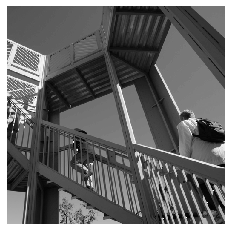

In [30]:
ascent = misc.ascent()
plt.imshow(ascent, cmap='gray')
plt.axis('off')
plt.show()

รูปที่ 4.3 ภาพบันไดจากไลบรารี scipy.misc

ตรวจจับขอบแนวตั้งโดยสังวัตนาการกับเคอร์เนล $h$ การกำหนด mode='same' จะได้เอาต์พุตเป็นเมทริกซ์ขนาดเท่ากับอินพุต 
แสดงภาพเอาต์พุตได้ดังรูปที่ 4.4

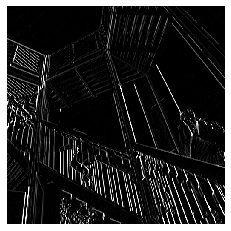

In [31]:
ascent_vertedge = signal.convolve2d(ascent,h,mode='same')
plt.imshow(ascent_vertedge, cmap='gray',vmin=0,vmax=255)
plt.axis('off')
plt.show()

รูปที่ 4.4 ผลจากการตรวจจับขอบของภาพบันไดในรูปที่ 4.3

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>